In [1]:
import boto3

import pandas as pd
from io import StringIO, BytesIO
from datetime import datetime, timedelta

import sklearn
import matplotlib.pyplot as plt

In [2]:
class Extract():
    def __init__(self, arg_date, src_format, src_bucket, trg_bucket, columns, key, s3, bucket):

        # Parameters/Configurations
        self.arg_date = arg_date
        self.src_format = src_format
        self.src_bucket = src_bucket
        self.trg_bucket = trg_bucket
        self.columns = columns
        self.key = key
        self.s3 = s3
        self.bucket = bucket
        
    def read_csv_to_df(self, filename,bucket):
        csv_obj = bucket.Object(key=filename).get().get('Body').read().decode('utf-8')
        data = StringIO(csv_obj)
        df = pd.read_csv(data, delimiter=',')
        return df

    def return_objects(self):
        arg_date_dt = datetime.strptime(self.arg_date, self.src_format).date() - timedelta(days=1)
        print(arg_date_dt)        
        objects = [obj for obj in self.bucket.objects.all() if datetime.strptime(obj.key.split('/')[0], self.src_format).date() >= arg_date_dt]
        return objects

    def extract(self, objects,columns,bucket):
        df_all = pd.concat([self.read_csv_to_df(obj.key, bucket) for obj in objects], ignore_index=True)
        df_all = df_all.loc[:, columns]
        df_all.dropna(inplace=True)
        print(df_all)
        return df_all


In [3]:
class Transform():

    def transform_report(self, df_all, arg_date, columns):

        df_all = df_all.loc[:, columns]
        df_all.dropna(inplace=True)

        df_all = df_all.loc[(df_all["Time"] >= '08:00') & (df_all["Time"]<='12:00'),['ISIN', 'Date', 'Time', 'StartPrice', 'EndPrice']]
        df_all.shape
        df_all = df_all.round(decimals=2)
        df_all = df_all[df_all.Date >= arg_date]

        df_all['STD'] = df_all[["StartPrice", "EndPrice"]].std(axis = 1)
        df_all

        df_all['MXN'] = df_all['EndPrice'] * 22.83
        df_all

        df_all.plot(x='EndPrice', y='MXN', style='o')

        plt.title('EndPrice - MXN')
        plt.xlabel('EndPrice')
        plt.ylabel('MXN')
        plt.show()

        x=df_all['EndPrice'].values.reshape(-1,1)
        y=df_all['MXN'].values.reshape(-1,1)

        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(x_train, y_train)

        print(lr.intercept_)
        print(lr.coef_)

        y_pred = lr.predict(x_test)

        df_prediccion = pd.DataFrame({'Actual': y_test.flatten(), 'Prediccion': y_pred.flatten()})
        df_prediccion

        plt.scatter(x_test, y_test, color='blue')
        plt.plot(x_test, y_pred, color='red', linewidth=2)
        plt.show()

        df_all=pd.concat([df_all, df_prediccion])
        df_all = df_all.infer_objects()
        df_all.dtypes
        df_all
        
        print(df_all)
        return df_all
        

In [4]:
class Load():
        
    def write_df_to_s3(self, df_all,s3,trg_bucket,key):
        out_buffer = BytesIO()
        df_all.to_parquet(out_buffer, index=False)
        bucket_target = s3.Bucket(trg_bucket)
        bucket_target.put_object(Body=out_buffer.getvalue(), Key=key)
        return bucket_target

    def load(self, bucket_target):
        objKey=[]
        for obj in bucket_target.objects.all():
            objKey.append(obj.key)
        prq_obj = bucket_target.Object(key=objKey[-1]).get().get('Body').read()
        data = BytesIO(prq_obj)
        return data

    def etl_report(self, bucket_target):
        df_report = pd.read_parquet(self.load(bucket_target))
        return df_report

In [5]:

def main():
    arg_date = '2022-04-07'
    src_format = '%Y-%m-%d'
    src_bucket = 'deutsche-boerse-xetra-pds'
    trg_bucket = 'xetra-bucket-gerardo-2022'
    columns = ['ISIN', 'Date', 'Time', 'StartPrice', 'MaxPrice', 'MinPrice', 'EndPrice', 'TradedVolume']
    key = 'xetra_daily_report_' + datetime.today().strftime("%Y%m%d_%H%M%S") + '.parquet'
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(src_bucket)

    ext = Extract(arg_date, src_format, src_bucket, trg_bucket, columns, key, s3, bucket)
    
    objects = ext.return_objects()
    df_all = ext.extract(objects,columns,bucket)
    
    tran = Transform()
    df_all = tran.transform_report(df_all, arg_date, columns)
    

    ld = Load()
    bucket_target = ld.write_df_to_s3(df_all,s3,trg_bucket,key)
    

    print(ld.etl_report(bucket_target))

2022-04-06
                ISIN        Date   Time StartPrice MaxPrice MinPrice EndPrice  \
0       AT0000A0E9W5  2022-04-06  07:00       17.8     17.8    17.79     17.8   
1       DE000A0DJ6J9  2022-04-06  07:00      43.02    43.02    43.02    43.02   
2       DE000A0D6554  2022-04-06  07:00     17.145    17.15    16.91    16.91   
3       DE000A0D9PT0  2022-04-06  07:00      195.8   196.85    195.6   196.85   
4       DE000A0HN5C6  2022-04-06  07:00      30.71    30.71    30.71    30.71   
...              ...         ...    ...        ...      ...      ...      ...   
329101  DE0006231004  2022-04-08  15:42      27.55    27.55    27.55    27.55   
329102  DE000A0JL9W6  2022-04-08  15:43       85.5     85.5     85.5     85.5   
329103  DE000A0WMPJ6  2022-04-08  15:43       19.5     19.5     19.5     19.5   
329104  DE000A0WMPJ6  2022-04-08  15:44       19.5     19.5     19.5     19.5   
329105  GB0007980591  2022-04-08  15:44      4.681    4.681    4.681    4.681   

       TradedVol

C:\Users\Gerardo Rmz\.virtualenvs\proyectoDatosNube--50BloDe\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


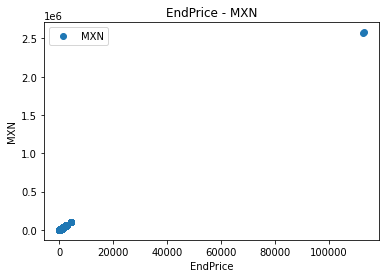

[6.82121026e-12]
[[22.83]]


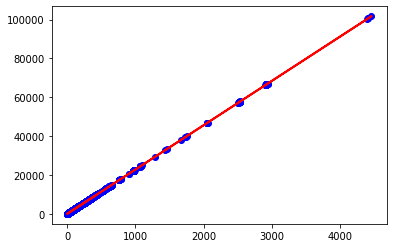

                ISIN        Date   Time  StartPrice  EndPrice       STD  \
133079  AT0000652011  2022-04-07  08:00      30.350    30.350  0.000000   
133080  CA32076V1031  2022-04-07  08:00      12.032    12.032  0.000000   
133081  DE000ETFL011  2022-04-07  08:00     126.940   126.820  0.084853   
133082  DE0005933931  2022-04-07  08:00     119.860   119.740  0.084853   
133083  LU0274211480  2022-04-07  08:00     135.280   135.180  0.070711   
...              ...         ...    ...         ...       ...       ...   
17005            NaN         NaN    NaN         NaN       NaN       NaN   
17006            NaN         NaN    NaN         NaN       NaN       NaN   
17007            NaN         NaN    NaN         NaN       NaN       NaN   
17008            NaN         NaN    NaN         NaN       NaN       NaN   
17009            NaN         NaN    NaN         NaN       NaN       NaN   

               MXN      Actual  Prediccion  
133079   692.89050         NaN         NaN  
133080   

In [6]:
main()